# All image csv files

In [3]:
import os
import csv

def create_csv(image_folder, csv_file_path):
    # CSV header
    fieldnames = ['HospitalID', 'PatientID', 'ImageID', 'ImagePath', 'Label']
    
    # open the CSV file in write mode
    with open(csv_file_path, 'w', newline='') as csvfile:
        # Create a CSV writer object and write the header
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        for filename in sorted(os.listdir(image_folder)):
            # complete image file path
            image_path = os.path.join(image_folder, filename)

            # filename to extract HospitalID, PatientID, image number, and image label
            parts = filename.split('_')
            hospital_id = parts[3]
            patient_id = parts[1]
            image_number = parts[6]
            image_label = parts[4]

            # write data into the CSV file
            writer.writerow({
                'HospitalID': hospital_id,
                'PatientID': patient_id,
                'ImageID': image_number,
                'ImagePath': image_path,
                'Label': image_label
            })

    # created and saved
    print("CSV file has been created and saved to:", csv_file_path)


image_folder = "/local/data1/honzh073/data/8bit_down224"
csv_file_path = "/local/data1/honzh073/local_repository/FL/code/6_test_global_model/csv_files/all_image.csv"
create_csv(image_folder, csv_file_path)


CSV file has been created and saved to: /local/data1/honzh073/local_repository/FL/code/6_test_global_model/csv_files/all_image.csv


# Custom Dataset and test 100 times average

In [5]:
# Custom dataset class
import os
import csv
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torchvision import models
from torchvision import transforms
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
import torch.nn.functional as F

# custom dataset on csv files
class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = []
        self.labels = []  # Store labels separately
        self.patient_ids = []  # Store patient IDs separately
        self.transform = transform
        
        # read csv
        with open(csv_file, 'r') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                image_path = row['ImagePath']
                label = row['Label']
                patient_id = row['PatientID']  # Assuming 'PatientID' is the column name in your CSV file

                if label == 'NFF':
                    label = 0
                elif label == 'AFF':
                    label = 1
                else:
                    raise ValueError("Invalid label in CSV file.")
                self.data.append((image_path, label))
                self.labels.append(label)
                self.patient_ids.append(patient_id)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, label = self.data[idx]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from sklearn.model_selection import StratifiedKFold
import random
import pandas as pd
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

# ------------------------------------------------------------------------------------------------------
def generate_random_pick_dataset(seed, excluded_hospitals, input_csv_path, output_csv_path):
    random.seed(seed)
    
    # Read the original CSV file
    df = pd.read_csv(input_csv_path)
    
    # Randomly select patients from non-excluded hospitals
    selected_data = []
    for hospital_id in df['HospitalID'].unique():
        if hospital_id not in excluded_hospitals:
            patients = df[df['HospitalID'] == hospital_id]['PatientID'].unique()
            selected_patients = random.sample(list(patients), min(3, len(patients)))
            for patient_id in selected_patients:
                patient_data = df[(df['HospitalID'] == hospital_id) & (df['PatientID'] == patient_id)]
                selected_data.append(patient_data)
    
    # Concatenate selected data to create a new DataFrame
    selected_df = pd.concat(selected_data)
    
    # Save the new DataFrame as a CSV file
    selected_df.to_csv(output_csv_path, index=False)
    
    # Return the output file path
    return output_csv_path
# ------------------------------------------------------------------------------------------------------
def test_model(model, test_dataset, batch_size):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
    model = model.to(device)

    model.eval()
    
    correct_test_nff = 0
    correct_test_aff = 0
    total_nff = 0
    total_aff = 0
    total_test = 0
    test_loss = 0
    
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        all_predictions = []
        all_labels = []
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total_test += labels.size(0)
            total_nff += (labels == 0).sum().item()
            total_aff += (labels == 1).sum().item()
            correct_test_nff += ((predicted == labels) & (labels == 0)).sum().item()
            correct_test_aff += ((predicted == labels) & (labels == 1)).sum().item()
            test_loss += loss.item()

    test_accuracy_nff = 100 * correct_test_nff / total_nff
    test_accuracy_aff = 100 * correct_test_aff / total_aff
    test_accuracy_total = 100 * (correct_test_nff + correct_test_aff) / total_test
    test_loss /= len(test_loader)
    
    auc_score = roc_auc_score(all_labels, all_predictions)
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    class_labels = {0: 'NFF', 1: 'AFF'}
    classification_rep = classification_report(all_labels, all_predictions, target_names=[class_labels[i] for i in range(len(class_labels))])
    
    # Store metrics in a dictionary
    metrics = {
        "Test Loss": test_loss,
        "Total Test Accuracy": test_accuracy_total,
        "Test Accuracy (NFF)": test_accuracy_nff,
        "Test Accuracy (AFF)": test_accuracy_aff,
        "AUC": auc_score,
        "Confusion Matrix": conf_matrix,
        "Classification Report": classification_rep
    }
    return metrics
# ------------------------------------------------------------------------------------------------------
# Set random seed for reproducibility
def run_100_times(model):
    # Define the excluded hospitals and file paths
    excluded_hospitals = [18, 43, 55, 100]
    input_csv_path = '/local/data1/honzh073/local_repository/FL/code/6_test_global_model/csv_files/all_image.csv'
    output_csv_path = '/local/data1/honzh073/local_repository/FL/code/6_test_global_model/csv_files/randompick_patient_data.csv'

    # Initialize lists to store metrics
    test_metrics_list = []

    # Generate random seeds from 1 to 100
    for seed in range(1, 101):
        print(f"Seed: {seed} / 100", end='\r')
        # Generate random pick dataset
        randompick_patient_data_path = generate_random_pick_dataset(seed, excluded_hospitals, input_csv_path, output_csv_path)
        
        # Load test_dataset using random pick data
        test_dataset = CustomDataset(randompick_patient_data_path, transform=test_transform)  # Define your CustomDataset and transform
        
        # Perform testing and collect metrics
        test_metrics = test_model(model, test_dataset, batch_size=8)  # Use your batch size
        test_metrics_list.append(test_metrics)

    # Calculate mean and standard deviation of metrics
    test_loss_values = [metrics['Test Loss'] for metrics in test_metrics_list]
    total_accuracy_values = [metrics['Total Test Accuracy'] for metrics in test_metrics_list]
    nff_accuracy_values = [metrics['Test Accuracy (NFF)'] for metrics in test_metrics_list]
    aff_accuracy_values = [metrics['Test Accuracy (AFF)'] for metrics in test_metrics_list]
    auc_values = [metrics['AUC'] for metrics in test_metrics_list]

    mean_test_loss = sum(test_loss_values) / len(test_loss_values)
    mean_total_accuracy = sum(total_accuracy_values) / len(total_accuracy_values)
    mean_nff_accuracy = sum(nff_accuracy_values) / len(nff_accuracy_values)
    mean_aff_accuracy = sum(aff_accuracy_values) / len(aff_accuracy_values)
    mean_auc = sum(auc_values) / len(auc_values)

    std_test_loss = (sum((x - mean_test_loss) ** 2 for x in test_loss_values) / len(test_loss_values)) ** 0.5
    std_total_accuracy = (sum((x - mean_total_accuracy) ** 2 for x in total_accuracy_values) / len(total_accuracy_values)) ** 0.5
    std_nff_accuracy = (sum((x - mean_nff_accuracy) ** 2 for x in nff_accuracy_values) / len(nff_accuracy_values)) ** 0.5
    std_aff_accuracy = (sum((x - mean_aff_accuracy) ** 2 for x in aff_accuracy_values) / len(aff_accuracy_values)) ** 0.5
    std_auc = (sum((x - mean_auc) ** 2 for x in auc_values) / len(auc_values)) ** 0.5

    # Print mean and standard deviation values
    # Print mean and standard deviation values with 4 decimal places
    print("Mean Test Loss:", round(mean_test_loss, 4))
    print("Standard Deviation Test Loss:", round(std_test_loss, 4))
    print("Mean Total Accuracy:", round(mean_total_accuracy, 4))
    print("Standard Deviation Total Accuracy:", round(std_total_accuracy, 4))
    print("Mean NFF Accuracy:", round(mean_nff_accuracy, 4))
    print("Standard Deviation NFF Accuracy:", round(std_nff_accuracy, 4))
    print("Mean AFF Accuracy:", round(mean_aff_accuracy, 4))
    print("Standard Deviation AFF Accuracy:", round(std_aff_accuracy, 4))
    print("Mean AUC:", round(mean_auc, 4))
    print("Standard Deviation AUC:", round(std_auc, 4))



# VGG 19

In [8]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import vgg19, VGG19_Weights

torch.hub.set_dir('/local/data1/honzh073/download/TORCH_PRETRAINED')
    
class CustomNet(nn.Module):
    def __init__(self, num_classes=2, freeze_percentage=0.5):
        super(CustomNet, self).__init__()

        # Load the pre-trained VGG19 model
        vgg19_model = models.vgg19(weights=VGG19_Weights.DEFAULT)

        # Extract features (all layers except the classifier)
        self.features = nn.Sequential(*list(vgg19_model.features.children()))

        # Calculate the index where to split the layers
        total_layers = len(list(self.features.children()))
        split_idx = int(total_layers * freeze_percentage)

        # Split the layers into groups for freezing and non-freezing
        children = list(self.features.children())
        self.frozen_features = nn.Sequential(*children[:split_idx])
        self.unfrozen_features = nn.Sequential(*children[split_idx:])

        # Freeze layers in self.frozen_features
        for param in self.frozen_features.parameters():
            param.requires_grad = False

        # Define the final fully connected layer
        in_features = vgg19_model.classifier[0].in_features
        self.classifier = nn.Linear(in_features, num_classes)  # VGG19's last feature map has 512 channels

    def forward(self, x):
        x = self.frozen_features(x)
        x = self.unfrozen_features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# create net
model = CustomNet(num_classes=2)  # num_classes 2

# checkpoint
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

global_path = '/local/data1/honzh073/data/admin@liu.se/transfer/817a39b8-e994-4e85-907b-e839ba93cb79/workspace/app_server/FL_global_model.pt'

checkpoint = torch.load(global_path, map_location=device)

# print(checkpoint.keys())

# modify checkpoint keys，match model
# load model weights
state_dict = checkpoint['model']
modified_state_dict = {}
for key, value in state_dict.items():
    # modify key names，match model layers
    new_key = key.replace("model.", "")
    modified_state_dict[new_key] = value

# load weights to model
model.load_state_dict(modified_state_dict)
model = model.to(device)
model.eval()

run_100_times(model)


KeyboardInterrupt: 

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


device(type='cpu')

# ResNet 50


In [56]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import resnet101, ResNet101_Weights
from torchvision.models import resnet50, ResNet50_Weights

torch.hub.set_dir('/local/data1/honzh073/download/TORCH_PRETRAINED')

class CustomNet(nn.Module):
    def __init__(self, num_classes=2, freeze_percentage=0.5):
        super(CustomNet, self).__init__()

        self.features = models.resnet50(weights=ResNet50_Weights.DEFAULT)

        # Calculate the index where to split the layerszh
        total_layers = len(list(self.features.children()))
        split_idx = int(total_layers * freeze_percentage)

        # Split the layers into groups for freezing and non-freezing
        children = list(self.features.children())
        self.frozen_features = nn.Sequential(*children[:split_idx])
        self.unfrozen_features = nn.Sequential(*children[split_idx:-1])  # Exclude the last layer

        # Freeze layers in self.frozen_features
        for param in self.frozen_features.parameters():
            param.requires_grad = False

        # Define the final fully connected layer
        self.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.frozen_features(x)
        x = self.unfrozen_features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
# create net
model = CustomNet(num_classes=2)  # num_classes 2

# checkpoint
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# resnet50_freeze_Adam 100 round 
global_path = '/local/data1/honzh073/data/suzuki.ad.liu.se/resnet50_50_Adam_100round/app_server/FL_global_model.pt'

# 200 round resnet50_freeze_RMSprop
# global_path = '/local/data1/honzh073/data/suzuki.ad.liu.se/transfer/resnet50_50%freeze_RMSprop_100round/workspace/app_server/FL_global_model.pt'

checkpoint = torch.load(global_path, map_location=device)
# print(checkpoint.keys())

# modify checkpoint keys，match model
# load model weights
state_dict = checkpoint['model']
modified_state_dict = {}
for key, value in state_dict.items():
    # modify key names，match model layers
    new_key = key.replace("model.", "")
    modified_state_dict[new_key] = value

# load weights to model
model.load_state_dict(modified_state_dict)
model = model.to(device)
model.eval()

# Resnet 101 on single hospital
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# hospital 100
test_dataset = CustomDataset('/local/data1/honzh073/local_repository/FL/code/6_model_test/hospital100.csv', transform=test_transform)

# random pick
# test_dataset = CustomDataset('/local/data1/honzh073/local_repository/FL/code/6_model_test/randompick_patient_data.csv', transform=test_transform)

# For test dataset
test_NFF_count = sum(1 for _, label in test_dataset if label == 0)  # 0 NFF
test_AFF_count = sum(1 for _, label in test_dataset if label == 1)  # 1 AFF
print(f"AFF: {test_AFF_count}, ratio: {test_AFF_count / (test_AFF_count + test_NFF_count):.2f}")
print(f"NFF: {test_NFF_count}, ratio: {test_NFF_count / (test_AFF_count + test_NFF_count):.2f}")

test_model(model, test_dataset=test_dataset, batch_size=16)


RuntimeError: Error(s) in loading state_dict for CustomNet:
	Unexpected key(s) in state_dict: "features.layer3.6.conv1.weight", "features.layer3.6.bn1.weight", "features.layer3.6.bn1.bias", "features.layer3.6.bn1.running_mean", "features.layer3.6.bn1.running_var", "features.layer3.6.bn1.num_batches_tracked", "features.layer3.6.conv2.weight", "features.layer3.6.bn2.weight", "features.layer3.6.bn2.bias", "features.layer3.6.bn2.running_mean", "features.layer3.6.bn2.running_var", "features.layer3.6.bn2.num_batches_tracked", "features.layer3.6.conv3.weight", "features.layer3.6.bn3.weight", "features.layer3.6.bn3.bias", "features.layer3.6.bn3.running_mean", "features.layer3.6.bn3.running_var", "features.layer3.6.bn3.num_batches_tracked", "features.layer3.7.conv1.weight", "features.layer3.7.bn1.weight", "features.layer3.7.bn1.bias", "features.layer3.7.bn1.running_mean", "features.layer3.7.bn1.running_var", "features.layer3.7.bn1.num_batches_tracked", "features.layer3.7.conv2.weight", "features.layer3.7.bn2.weight", "features.layer3.7.bn2.bias", "features.layer3.7.bn2.running_mean", "features.layer3.7.bn2.running_var", "features.layer3.7.bn2.num_batches_tracked", "features.layer3.7.conv3.weight", "features.layer3.7.bn3.weight", "features.layer3.7.bn3.bias", "features.layer3.7.bn3.running_mean", "features.layer3.7.bn3.running_var", "features.layer3.7.bn3.num_batches_tracked", "features.layer3.8.conv1.weight", "features.layer3.8.bn1.weight", "features.layer3.8.bn1.bias", "features.layer3.8.bn1.running_mean", "features.layer3.8.bn1.running_var", "features.layer3.8.bn1.num_batches_tracked", "features.layer3.8.conv2.weight", "features.layer3.8.bn2.weight", "features.layer3.8.bn2.bias", "features.layer3.8.bn2.running_mean", "features.layer3.8.bn2.running_var", "features.layer3.8.bn2.num_batches_tracked", "features.layer3.8.conv3.weight", "features.layer3.8.bn3.weight", "features.layer3.8.bn3.bias", "features.layer3.8.bn3.running_mean", "features.layer3.8.bn3.running_var", "features.layer3.8.bn3.num_batches_tracked", "features.layer3.9.conv1.weight", "features.layer3.9.bn1.weight", "features.layer3.9.bn1.bias", "features.layer3.9.bn1.running_mean", "features.layer3.9.bn1.running_var", "features.layer3.9.bn1.num_batches_tracked", "features.layer3.9.conv2.weight", "features.layer3.9.bn2.weight", "features.layer3.9.bn2.bias", "features.layer3.9.bn2.running_mean", "features.layer3.9.bn2.running_var", "features.layer3.9.bn2.num_batches_tracked", "features.layer3.9.conv3.weight", "features.layer3.9.bn3.weight", "features.layer3.9.bn3.bias", "features.layer3.9.bn3.running_mean", "features.layer3.9.bn3.running_var", "features.layer3.9.bn3.num_batches_tracked", "features.layer3.10.conv1.weight", "features.layer3.10.bn1.weight", "features.layer3.10.bn1.bias", "features.layer3.10.bn1.running_mean", "features.layer3.10.bn1.running_var", "features.layer3.10.bn1.num_batches_tracked", "features.layer3.10.conv2.weight", "features.layer3.10.bn2.weight", "features.layer3.10.bn2.bias", "features.layer3.10.bn2.running_mean", "features.layer3.10.bn2.running_var", "features.layer3.10.bn2.num_batches_tracked", "features.layer3.10.conv3.weight", "features.layer3.10.bn3.weight", "features.layer3.10.bn3.bias", "features.layer3.10.bn3.running_mean", "features.layer3.10.bn3.running_var", "features.layer3.10.bn3.num_batches_tracked", "features.layer3.11.conv1.weight", "features.layer3.11.bn1.weight", "features.layer3.11.bn1.bias", "features.layer3.11.bn1.running_mean", "features.layer3.11.bn1.running_var", "features.layer3.11.bn1.num_batches_tracked", "features.layer3.11.conv2.weight", "features.layer3.11.bn2.weight", "features.layer3.11.bn2.bias", "features.layer3.11.bn2.running_mean", "features.layer3.11.bn2.running_var", "features.layer3.11.bn2.num_batches_tracked", "features.layer3.11.conv3.weight", "features.layer3.11.bn3.weight", "features.layer3.11.bn3.bias", "features.layer3.11.bn3.running_mean", "features.layer3.11.bn3.running_var", "features.layer3.11.bn3.num_batches_tracked", "features.layer3.12.conv1.weight", "features.layer3.12.bn1.weight", "features.layer3.12.bn1.bias", "features.layer3.12.bn1.running_mean", "features.layer3.12.bn1.running_var", "features.layer3.12.bn1.num_batches_tracked", "features.layer3.12.conv2.weight", "features.layer3.12.bn2.weight", "features.layer3.12.bn2.bias", "features.layer3.12.bn2.running_mean", "features.layer3.12.bn2.running_var", "features.layer3.12.bn2.num_batches_tracked", "features.layer3.12.conv3.weight", "features.layer3.12.bn3.weight", "features.layer3.12.bn3.bias", "features.layer3.12.bn3.running_mean", "features.layer3.12.bn3.running_var", "features.layer3.12.bn3.num_batches_tracked", "features.layer3.13.conv1.weight", "features.layer3.13.bn1.weight", "features.layer3.13.bn1.bias", "features.layer3.13.bn1.running_mean", "features.layer3.13.bn1.running_var", "features.layer3.13.bn1.num_batches_tracked", "features.layer3.13.conv2.weight", "features.layer3.13.bn2.weight", "features.layer3.13.bn2.bias", "features.layer3.13.bn2.running_mean", "features.layer3.13.bn2.running_var", "features.layer3.13.bn2.num_batches_tracked", "features.layer3.13.conv3.weight", "features.layer3.13.bn3.weight", "features.layer3.13.bn3.bias", "features.layer3.13.bn3.running_mean", "features.layer3.13.bn3.running_var", "features.layer3.13.bn3.num_batches_tracked", "features.layer3.14.conv1.weight", "features.layer3.14.bn1.weight", "features.layer3.14.bn1.bias", "features.layer3.14.bn1.running_mean", "features.layer3.14.bn1.running_var", "features.layer3.14.bn1.num_batches_tracked", "features.layer3.14.conv2.weight", "features.layer3.14.bn2.weight", "features.layer3.14.bn2.bias", "features.layer3.14.bn2.running_mean", "features.layer3.14.bn2.running_var", "features.layer3.14.bn2.num_batches_tracked", "features.layer3.14.conv3.weight", "features.layer3.14.bn3.weight", "features.layer3.14.bn3.bias", "features.layer3.14.bn3.running_mean", "features.layer3.14.bn3.running_var", "features.layer3.14.bn3.num_batches_tracked", "features.layer3.15.conv1.weight", "features.layer3.15.bn1.weight", "features.layer3.15.bn1.bias", "features.layer3.15.bn1.running_mean", "features.layer3.15.bn1.running_var", "features.layer3.15.bn1.num_batches_tracked", "features.layer3.15.conv2.weight", "features.layer3.15.bn2.weight", "features.layer3.15.bn2.bias", "features.layer3.15.bn2.running_mean", "features.layer3.15.bn2.running_var", "features.layer3.15.bn2.num_batches_tracked", "features.layer3.15.conv3.weight", "features.layer3.15.bn3.weight", "features.layer3.15.bn3.bias", "features.layer3.15.bn3.running_mean", "features.layer3.15.bn3.running_var", "features.layer3.15.bn3.num_batches_tracked", "features.layer3.16.conv1.weight", "features.layer3.16.bn1.weight", "features.layer3.16.bn1.bias", "features.layer3.16.bn1.running_mean", "features.layer3.16.bn1.running_var", "features.layer3.16.bn1.num_batches_tracked", "features.layer3.16.conv2.weight", "features.layer3.16.bn2.weight", "features.layer3.16.bn2.bias", "features.layer3.16.bn2.running_mean", "features.layer3.16.bn2.running_var", "features.layer3.16.bn2.num_batches_tracked", "features.layer3.16.conv3.weight", "features.layer3.16.bn3.weight", "features.layer3.16.bn3.bias", "features.layer3.16.bn3.running_mean", "features.layer3.16.bn3.running_var", "features.layer3.16.bn3.num_batches_tracked", "features.layer3.17.conv1.weight", "features.layer3.17.bn1.weight", "features.layer3.17.bn1.bias", "features.layer3.17.bn1.running_mean", "features.layer3.17.bn1.running_var", "features.layer3.17.bn1.num_batches_tracked", "features.layer3.17.conv2.weight", "features.layer3.17.bn2.weight", "features.layer3.17.bn2.bias", "features.layer3.17.bn2.running_mean", "features.layer3.17.bn2.running_var", "features.layer3.17.bn2.num_batches_tracked", "features.layer3.17.conv3.weight", "features.layer3.17.bn3.weight", "features.layer3.17.bn3.bias", "features.layer3.17.bn3.running_mean", "features.layer3.17.bn3.running_var", "features.layer3.17.bn3.num_batches_tracked", "features.layer3.18.conv1.weight", "features.layer3.18.bn1.weight", "features.layer3.18.bn1.bias", "features.layer3.18.bn1.running_mean", "features.layer3.18.bn1.running_var", "features.layer3.18.bn1.num_batches_tracked", "features.layer3.18.conv2.weight", "features.layer3.18.bn2.weight", "features.layer3.18.bn2.bias", "features.layer3.18.bn2.running_mean", "features.layer3.18.bn2.running_var", "features.layer3.18.bn2.num_batches_tracked", "features.layer3.18.conv3.weight", "features.layer3.18.bn3.weight", "features.layer3.18.bn3.bias", "features.layer3.18.bn3.running_mean", "features.layer3.18.bn3.running_var", "features.layer3.18.bn3.num_batches_tracked", "features.layer3.19.conv1.weight", "features.layer3.19.bn1.weight", "features.layer3.19.bn1.bias", "features.layer3.19.bn1.running_mean", "features.layer3.19.bn1.running_var", "features.layer3.19.bn1.num_batches_tracked", "features.layer3.19.conv2.weight", "features.layer3.19.bn2.weight", "features.layer3.19.bn2.bias", "features.layer3.19.bn2.running_mean", "features.layer3.19.bn2.running_var", "features.layer3.19.bn2.num_batches_tracked", "features.layer3.19.conv3.weight", "features.layer3.19.bn3.weight", "features.layer3.19.bn3.bias", "features.layer3.19.bn3.running_mean", "features.layer3.19.bn3.running_var", "features.layer3.19.bn3.num_batches_tracked", "features.layer3.20.conv1.weight", "features.layer3.20.bn1.weight", "features.layer3.20.bn1.bias", "features.layer3.20.bn1.running_mean", "features.layer3.20.bn1.running_var", "features.layer3.20.bn1.num_batches_tracked", "features.layer3.20.conv2.weight", "features.layer3.20.bn2.weight", "features.layer3.20.bn2.bias", "features.layer3.20.bn2.running_mean", "features.layer3.20.bn2.running_var", "features.layer3.20.bn2.num_batches_tracked", "features.layer3.20.conv3.weight", "features.layer3.20.bn3.weight", "features.layer3.20.bn3.bias", "features.layer3.20.bn3.running_mean", "features.layer3.20.bn3.running_var", "features.layer3.20.bn3.num_batches_tracked", "features.layer3.21.conv1.weight", "features.layer3.21.bn1.weight", "features.layer3.21.bn1.bias", "features.layer3.21.bn1.running_mean", "features.layer3.21.bn1.running_var", "features.layer3.21.bn1.num_batches_tracked", "features.layer3.21.conv2.weight", "features.layer3.21.bn2.weight", "features.layer3.21.bn2.bias", "features.layer3.21.bn2.running_mean", "features.layer3.21.bn2.running_var", "features.layer3.21.bn2.num_batches_tracked", "features.layer3.21.conv3.weight", "features.layer3.21.bn3.weight", "features.layer3.21.bn3.bias", "features.layer3.21.bn3.running_mean", "features.layer3.21.bn3.running_var", "features.layer3.21.bn3.num_batches_tracked", "features.layer3.22.conv1.weight", "features.layer3.22.bn1.weight", "features.layer3.22.bn1.bias", "features.layer3.22.bn1.running_mean", "features.layer3.22.bn1.running_var", "features.layer3.22.bn1.num_batches_tracked", "features.layer3.22.conv2.weight", "features.layer3.22.bn2.weight", "features.layer3.22.bn2.bias", "features.layer3.22.bn2.running_mean", "features.layer3.22.bn2.running_var", "features.layer3.22.bn2.num_batches_tracked", "features.layer3.22.conv3.weight", "features.layer3.22.bn3.weight", "features.layer3.22.bn3.bias", "features.layer3.22.bn3.running_mean", "features.layer3.22.bn3.running_var", "features.layer3.22.bn3.num_batches_tracked", "unfrozen_features.1.6.conv1.weight", "unfrozen_features.1.6.bn1.weight", "unfrozen_features.1.6.bn1.bias", "unfrozen_features.1.6.bn1.running_mean", "unfrozen_features.1.6.bn1.running_var", "unfrozen_features.1.6.bn1.num_batches_tracked", "unfrozen_features.1.6.conv2.weight", "unfrozen_features.1.6.bn2.weight", "unfrozen_features.1.6.bn2.bias", "unfrozen_features.1.6.bn2.running_mean", "unfrozen_features.1.6.bn2.running_var", "unfrozen_features.1.6.bn2.num_batches_tracked", "unfrozen_features.1.6.conv3.weight", "unfrozen_features.1.6.bn3.weight", "unfrozen_features.1.6.bn3.bias", "unfrozen_features.1.6.bn3.running_mean", "unfrozen_features.1.6.bn3.running_var", "unfrozen_features.1.6.bn3.num_batches_tracked", "unfrozen_features.1.7.conv1.weight", "unfrozen_features.1.7.bn1.weight", "unfrozen_features.1.7.bn1.bias", "unfrozen_features.1.7.bn1.running_mean", "unfrozen_features.1.7.bn1.running_var", "unfrozen_features.1.7.bn1.num_batches_tracked", "unfrozen_features.1.7.conv2.weight", "unfrozen_features.1.7.bn2.weight", "unfrozen_features.1.7.bn2.bias", "unfrozen_features.1.7.bn2.running_mean", "unfrozen_features.1.7.bn2.running_var", "unfrozen_features.1.7.bn2.num_batches_tracked", "unfrozen_features.1.7.conv3.weight", "unfrozen_features.1.7.bn3.weight", "unfrozen_features.1.7.bn3.bias", "unfrozen_features.1.7.bn3.running_mean", "unfrozen_features.1.7.bn3.running_var", "unfrozen_features.1.7.bn3.num_batches_tracked", "unfrozen_features.1.8.conv1.weight", "unfrozen_features.1.8.bn1.weight", "unfrozen_features.1.8.bn1.bias", "unfrozen_features.1.8.bn1.running_mean", "unfrozen_features.1.8.bn1.running_var", "unfrozen_features.1.8.bn1.num_batches_tracked", "unfrozen_features.1.8.conv2.weight", "unfrozen_features.1.8.bn2.weight", "unfrozen_features.1.8.bn2.bias", "unfrozen_features.1.8.bn2.running_mean", "unfrozen_features.1.8.bn2.running_var", "unfrozen_features.1.8.bn2.num_batches_tracked", "unfrozen_features.1.8.conv3.weight", "unfrozen_features.1.8.bn3.weight", "unfrozen_features.1.8.bn3.bias", "unfrozen_features.1.8.bn3.running_mean", "unfrozen_features.1.8.bn3.running_var", "unfrozen_features.1.8.bn3.num_batches_tracked", "unfrozen_features.1.9.conv1.weight", "unfrozen_features.1.9.bn1.weight", "unfrozen_features.1.9.bn1.bias", "unfrozen_features.1.9.bn1.running_mean", "unfrozen_features.1.9.bn1.running_var", "unfrozen_features.1.9.bn1.num_batches_tracked", "unfrozen_features.1.9.conv2.weight", "unfrozen_features.1.9.bn2.weight", "unfrozen_features.1.9.bn2.bias", "unfrozen_features.1.9.bn2.running_mean", "unfrozen_features.1.9.bn2.running_var", "unfrozen_features.1.9.bn2.num_batches_tracked", "unfrozen_features.1.9.conv3.weight", "unfrozen_features.1.9.bn3.weight", "unfrozen_features.1.9.bn3.bias", "unfrozen_features.1.9.bn3.running_mean", "unfrozen_features.1.9.bn3.running_var", "unfrozen_features.1.9.bn3.num_batches_tracked", "unfrozen_features.1.10.conv1.weight", "unfrozen_features.1.10.bn1.weight", "unfrozen_features.1.10.bn1.bias", "unfrozen_features.1.10.bn1.running_mean", "unfrozen_features.1.10.bn1.running_var", "unfrozen_features.1.10.bn1.num_batches_tracked", "unfrozen_features.1.10.conv2.weight", "unfrozen_features.1.10.bn2.weight", "unfrozen_features.1.10.bn2.bias", "unfrozen_features.1.10.bn2.running_mean", "unfrozen_features.1.10.bn2.running_var", "unfrozen_features.1.10.bn2.num_batches_tracked", "unfrozen_features.1.10.conv3.weight", "unfrozen_features.1.10.bn3.weight", "unfrozen_features.1.10.bn3.bias", "unfrozen_features.1.10.bn3.running_mean", "unfrozen_features.1.10.bn3.running_var", "unfrozen_features.1.10.bn3.num_batches_tracked", "unfrozen_features.1.11.conv1.weight", "unfrozen_features.1.11.bn1.weight", "unfrozen_features.1.11.bn1.bias", "unfrozen_features.1.11.bn1.running_mean", "unfrozen_features.1.11.bn1.running_var", "unfrozen_features.1.11.bn1.num_batches_tracked", "unfrozen_features.1.11.conv2.weight", "unfrozen_features.1.11.bn2.weight", "unfrozen_features.1.11.bn2.bias", "unfrozen_features.1.11.bn2.running_mean", "unfrozen_features.1.11.bn2.running_var", "unfrozen_features.1.11.bn2.num_batches_tracked", "unfrozen_features.1.11.conv3.weight", "unfrozen_features.1.11.bn3.weight", "unfrozen_features.1.11.bn3.bias", "unfrozen_features.1.11.bn3.running_mean", "unfrozen_features.1.11.bn3.running_var", "unfrozen_features.1.11.bn3.num_batches_tracked", "unfrozen_features.1.12.conv1.weight", "unfrozen_features.1.12.bn1.weight", "unfrozen_features.1.12.bn1.bias", "unfrozen_features.1.12.bn1.running_mean", "unfrozen_features.1.12.bn1.running_var", "unfrozen_features.1.12.bn1.num_batches_tracked", "unfrozen_features.1.12.conv2.weight", "unfrozen_features.1.12.bn2.weight", "unfrozen_features.1.12.bn2.bias", "unfrozen_features.1.12.bn2.running_mean", "unfrozen_features.1.12.bn2.running_var", "unfrozen_features.1.12.bn2.num_batches_tracked", "unfrozen_features.1.12.conv3.weight", "unfrozen_features.1.12.bn3.weight", "unfrozen_features.1.12.bn3.bias", "unfrozen_features.1.12.bn3.running_mean", "unfrozen_features.1.12.bn3.running_var", "unfrozen_features.1.12.bn3.num_batches_tracked", "unfrozen_features.1.13.conv1.weight", "unfrozen_features.1.13.bn1.weight", "unfrozen_features.1.13.bn1.bias", "unfrozen_features.1.13.bn1.running_mean", "unfrozen_features.1.13.bn1.running_var", "unfrozen_features.1.13.bn1.num_batches_tracked", "unfrozen_features.1.13.conv2.weight", "unfrozen_features.1.13.bn2.weight", "unfrozen_features.1.13.bn2.bias", "unfrozen_features.1.13.bn2.running_mean", "unfrozen_features.1.13.bn2.running_var", "unfrozen_features.1.13.bn2.num_batches_tracked", "unfrozen_features.1.13.conv3.weight", "unfrozen_features.1.13.bn3.weight", "unfrozen_features.1.13.bn3.bias", "unfrozen_features.1.13.bn3.running_mean", "unfrozen_features.1.13.bn3.running_var", "unfrozen_features.1.13.bn3.num_batches_tracked", "unfrozen_features.1.14.conv1.weight", "unfrozen_features.1.14.bn1.weight", "unfrozen_features.1.14.bn1.bias", "unfrozen_features.1.14.bn1.running_mean", "unfrozen_features.1.14.bn1.running_var", "unfrozen_features.1.14.bn1.num_batches_tracked", "unfrozen_features.1.14.conv2.weight", "unfrozen_features.1.14.bn2.weight", "unfrozen_features.1.14.bn2.bias", "unfrozen_features.1.14.bn2.running_mean", "unfrozen_features.1.14.bn2.running_var", "unfrozen_features.1.14.bn2.num_batches_tracked", "unfrozen_features.1.14.conv3.weight", "unfrozen_features.1.14.bn3.weight", "unfrozen_features.1.14.bn3.bias", "unfrozen_features.1.14.bn3.running_mean", "unfrozen_features.1.14.bn3.running_var", "unfrozen_features.1.14.bn3.num_batches_tracked", "unfrozen_features.1.15.conv1.weight", "unfrozen_features.1.15.bn1.weight", "unfrozen_features.1.15.bn1.bias", "unfrozen_features.1.15.bn1.running_mean", "unfrozen_features.1.15.bn1.running_var", "unfrozen_features.1.15.bn1.num_batches_tracked", "unfrozen_features.1.15.conv2.weight", "unfrozen_features.1.15.bn2.weight", "unfrozen_features.1.15.bn2.bias", "unfrozen_features.1.15.bn2.running_mean", "unfrozen_features.1.15.bn2.running_var", "unfrozen_features.1.15.bn2.num_batches_tracked", "unfrozen_features.1.15.conv3.weight", "unfrozen_features.1.15.bn3.weight", "unfrozen_features.1.15.bn3.bias", "unfrozen_features.1.15.bn3.running_mean", "unfrozen_features.1.15.bn3.running_var", "unfrozen_features.1.15.bn3.num_batches_tracked", "unfrozen_features.1.16.conv1.weight", "unfrozen_features.1.16.bn1.weight", "unfrozen_features.1.16.bn1.bias", "unfrozen_features.1.16.bn1.running_mean", "unfrozen_features.1.16.bn1.running_var", "unfrozen_features.1.16.bn1.num_batches_tracked", "unfrozen_features.1.16.conv2.weight", "unfrozen_features.1.16.bn2.weight", "unfrozen_features.1.16.bn2.bias", "unfrozen_features.1.16.bn2.running_mean", "unfrozen_features.1.16.bn2.running_var", "unfrozen_features.1.16.bn2.num_batches_tracked", "unfrozen_features.1.16.conv3.weight", "unfrozen_features.1.16.bn3.weight", "unfrozen_features.1.16.bn3.bias", "unfrozen_features.1.16.bn3.running_mean", "unfrozen_features.1.16.bn3.running_var", "unfrozen_features.1.16.bn3.num_batches_tracked", "unfrozen_features.1.17.conv1.weight", "unfrozen_features.1.17.bn1.weight", "unfrozen_features.1.17.bn1.bias", "unfrozen_features.1.17.bn1.running_mean", "unfrozen_features.1.17.bn1.running_var", "unfrozen_features.1.17.bn1.num_batches_tracked", "unfrozen_features.1.17.conv2.weight", "unfrozen_features.1.17.bn2.weight", "unfrozen_features.1.17.bn2.bias", "unfrozen_features.1.17.bn2.running_mean", "unfrozen_features.1.17.bn2.running_var", "unfrozen_features.1.17.bn2.num_batches_tracked", "unfrozen_features.1.17.conv3.weight", "unfrozen_features.1.17.bn3.weight", "unfrozen_features.1.17.bn3.bias", "unfrozen_features.1.17.bn3.running_mean", "unfrozen_features.1.17.bn3.running_var", "unfrozen_features.1.17.bn3.num_batches_tracked", "unfrozen_features.1.18.conv1.weight", "unfrozen_features.1.18.bn1.weight", "unfrozen_features.1.18.bn1.bias", "unfrozen_features.1.18.bn1.running_mean", "unfrozen_features.1.18.bn1.running_var", "unfrozen_features.1.18.bn1.num_batches_tracked", "unfrozen_features.1.18.conv2.weight", "unfrozen_features.1.18.bn2.weight", "unfrozen_features.1.18.bn2.bias", "unfrozen_features.1.18.bn2.running_mean", "unfrozen_features.1.18.bn2.running_var", "unfrozen_features.1.18.bn2.num_batches_tracked", "unfrozen_features.1.18.conv3.weight", "unfrozen_features.1.18.bn3.weight", "unfrozen_features.1.18.bn3.bias", "unfrozen_features.1.18.bn3.running_mean", "unfrozen_features.1.18.bn3.running_var", "unfrozen_features.1.18.bn3.num_batches_tracked", "unfrozen_features.1.19.conv1.weight", "unfrozen_features.1.19.bn1.weight", "unfrozen_features.1.19.bn1.bias", "unfrozen_features.1.19.bn1.running_mean", "unfrozen_features.1.19.bn1.running_var", "unfrozen_features.1.19.bn1.num_batches_tracked", "unfrozen_features.1.19.conv2.weight", "unfrozen_features.1.19.bn2.weight", "unfrozen_features.1.19.bn2.bias", "unfrozen_features.1.19.bn2.running_mean", "unfrozen_features.1.19.bn2.running_var", "unfrozen_features.1.19.bn2.num_batches_tracked", "unfrozen_features.1.19.conv3.weight", "unfrozen_features.1.19.bn3.weight", "unfrozen_features.1.19.bn3.bias", "unfrozen_features.1.19.bn3.running_mean", "unfrozen_features.1.19.bn3.running_var", "unfrozen_features.1.19.bn3.num_batches_tracked", "unfrozen_features.1.20.conv1.weight", "unfrozen_features.1.20.bn1.weight", "unfrozen_features.1.20.bn1.bias", "unfrozen_features.1.20.bn1.running_mean", "unfrozen_features.1.20.bn1.running_var", "unfrozen_features.1.20.bn1.num_batches_tracked", "unfrozen_features.1.20.conv2.weight", "unfrozen_features.1.20.bn2.weight", "unfrozen_features.1.20.bn2.bias", "unfrozen_features.1.20.bn2.running_mean", "unfrozen_features.1.20.bn2.running_var", "unfrozen_features.1.20.bn2.num_batches_tracked", "unfrozen_features.1.20.conv3.weight", "unfrozen_features.1.20.bn3.weight", "unfrozen_features.1.20.bn3.bias", "unfrozen_features.1.20.bn3.running_mean", "unfrozen_features.1.20.bn3.running_var", "unfrozen_features.1.20.bn3.num_batches_tracked", "unfrozen_features.1.21.conv1.weight", "unfrozen_features.1.21.bn1.weight", "unfrozen_features.1.21.bn1.bias", "unfrozen_features.1.21.bn1.running_mean", "unfrozen_features.1.21.bn1.running_var", "unfrozen_features.1.21.bn1.num_batches_tracked", "unfrozen_features.1.21.conv2.weight", "unfrozen_features.1.21.bn2.weight", "unfrozen_features.1.21.bn2.bias", "unfrozen_features.1.21.bn2.running_mean", "unfrozen_features.1.21.bn2.running_var", "unfrozen_features.1.21.bn2.num_batches_tracked", "unfrozen_features.1.21.conv3.weight", "unfrozen_features.1.21.bn3.weight", "unfrozen_features.1.21.bn3.bias", "unfrozen_features.1.21.bn3.running_mean", "unfrozen_features.1.21.bn3.running_var", "unfrozen_features.1.21.bn3.num_batches_tracked", "unfrozen_features.1.22.conv1.weight", "unfrozen_features.1.22.bn1.weight", "unfrozen_features.1.22.bn1.bias", "unfrozen_features.1.22.bn1.running_mean", "unfrozen_features.1.22.bn1.running_var", "unfrozen_features.1.22.bn1.num_batches_tracked", "unfrozen_features.1.22.conv2.weight", "unfrozen_features.1.22.bn2.weight", "unfrozen_features.1.22.bn2.bias", "unfrozen_features.1.22.bn2.running_mean", "unfrozen_features.1.22.bn2.running_var", "unfrozen_features.1.22.bn2.num_batches_tracked", "unfrozen_features.1.22.conv3.weight", "unfrozen_features.1.22.bn3.weight", "unfrozen_features.1.22.bn3.bias", "unfrozen_features.1.22.bn3.running_mean", "unfrozen_features.1.22.bn3.running_var", "unfrozen_features.1.22.bn3.num_batches_tracked". 

# ResNet 101
50% layer freezed

Round: 50, Optimizer: Adam, lr: 0.0001, Epoch: 2

AFF: 94, ratio: 0.16
NFF: 494, ratio: 0.84
Test Loss: 0.4253, Test Acc: 90.99%
AUC: 0.8472952019984494
Confusion Matrix:
[[464  30]
 [ 23  71]]
Classification Report:
              precision    recall  f1-score   support

         NFF       0.95      0.94      0.95       494
         AFF       0.70      0.76      0.73        94

    accuracy                           0.91       588
   macro avg       0.83      0.85      0.84       588
weighted avg       0.91      0.91      0.91       588



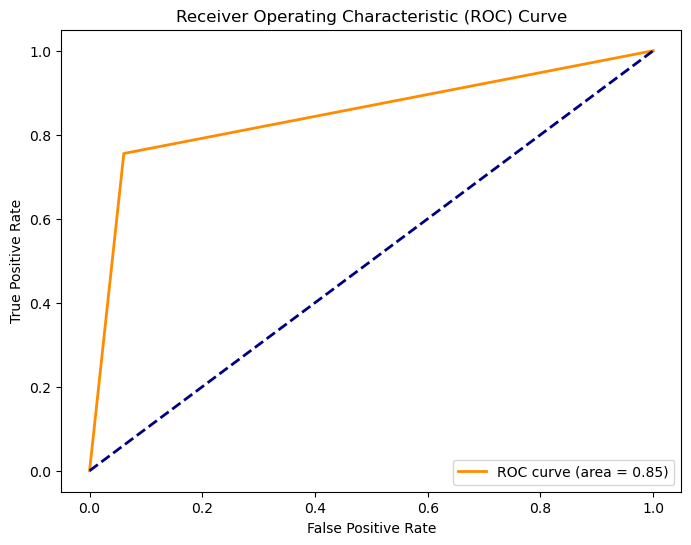

In [6]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import resnet101, ResNet101_Weights
from torchvision.models import resnet50, ResNet50_Weights

torch.hub.set_dir('/local/data1/honzh073/download/TORCH_PRETRAINED')

class CustomNet(nn.Module):
    def __init__(self, num_classes=2, freeze_percentage=0.5):
        super(CustomNet, self).__init__()

        self.features = models.resnet101(weights=ResNet101_Weights.DEFAULT)

        # Calculate the index where to split the layers
        total_layers = len(list(self.features.children()))
        split_idx = int(total_layers * freeze_percentage)

        # Split the layers into groups for freezing and non-freezing
        children = list(self.features.children())
        self.frozen_features = nn.Sequential(*children[:split_idx])
        self.unfrozen_features = nn.Sequential(*children[split_idx:-1])  # Exclude the last layer

        # Freeze layers in self.frozen_features
        for param in self.frozen_features.parameters():
            param.requires_grad = False

        # Define the final fully connected layer
        self.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.frozen_features(x)
        x = self.unfrozen_features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
# create net
model = CustomNet(num_classes=2)  # num_classes 2

# checkpoint
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# resnet 101, adam, 100 round
global_path = '/local/data1/honzh073/data/suzuki.ad.liu.se/f4c6fe6a-412e-4d88-a901-bce960c6f0d7/app_server/FL_global_model.pt'

# resnet 101, rmsprop, 200 round
# global_path = '/local/data1/honzh073/data/suzuki.ad.liu.se/transfer/resnet101_50_RSMprop_200round/workspace/app_server/FL_global_model.pt'

checkpoint = torch.load(global_path, map_location=device)
# print(checkpoint.keys())

# modify checkpoint keys，match model
# load model weights
state_dict = checkpoint['model']
modified_state_dict = {}
for key, value in state_dict.items():
    # modify key names，match model layers
    new_key = key.replace("model.", "")
    modified_state_dict[new_key] = value

# load weights to model
model.load_state_dict(modified_state_dict)
model = model.to(device)
model.eval()

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# random pick
test_dataset = CustomDataset('/local/data1/honzh073/local_repository/FL/code/6_model_test/randompick_patient_data.csv', transform=test_transform)

# For test dataset
test_NFF_count = sum(1 for _, label in test_dataset if label == 0)  # 0 NFF
test_AFF_count = sum(1 for _, label in test_dataset if label == 1)  # 1 AFF
print(f"AFF: {test_AFF_count}, ratio: {test_AFF_count / (test_AFF_count + test_NFF_count):.2f}")
print(f"NFF: {test_NFF_count}, ratio: {test_NFF_count / (test_AFF_count + test_NFF_count):.2f}")

test_model(model, test_dataset=test_dataset, batch_size=16)


# DenseNet 161


AFF: 94, ratio: 0.16
NFF: 494, ratio: 0.84
Test Loss: 0.3876, Test Acc: 85.54%
AUC: 0.560793349987079
Confusion Matrix:
[[491   3]
 [ 82  12]]
Classification Report:
              precision    recall  f1-score   support

         NFF       0.86      0.99      0.92       494
         AFF       0.80      0.13      0.22        94

    accuracy                           0.86       588
   macro avg       0.83      0.56      0.57       588
weighted avg       0.85      0.86      0.81       588



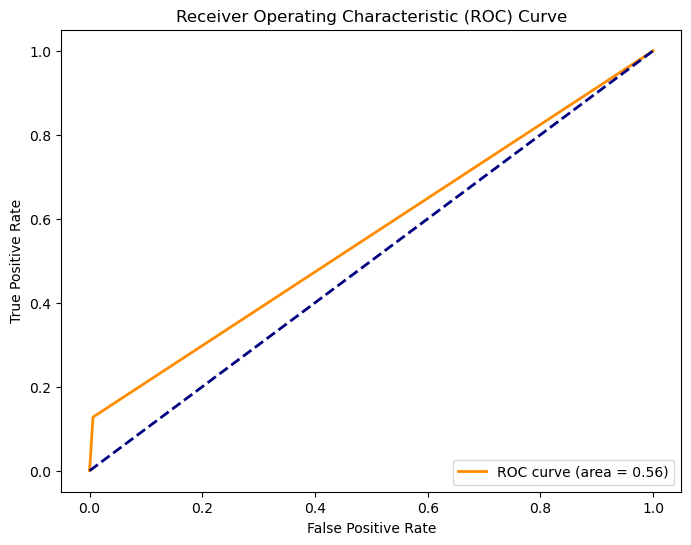

In [3]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import densenet161, DenseNet161_Weights

torch.hub.set_dir('/local/data1/honzh073/download/TORCH_PRETRAINED')

class CustomNet(nn.Module):
    def __init__(self, num_classes=2, freeze_percentage=0.5):
        super(CustomNet, self).__init__()

        self.features = models.densenet161(weights=DenseNet161_Weights.DEFAULT)

        # Calculate the index where to split the layers
        total_layers = len(list(self.features.children()))
        split_idx = int(total_layers * freeze_percentage)

        # Split the layers into groups for freezing and non-freezing
        children = list(self.features.children())
        self.frozen_features = nn.Sequential(*children[:split_idx])
        self.unfrozen_features = nn.Sequential(*children[split_idx:-1])  # Exclude the last layer

        # Freeze layers in self.frozen_features
        for param in self.frozen_features.parameters():
            param.requires_grad = False

        # Define the final fully connected layer
        self.fc = nn.Linear(2208, num_classes)  # DenseNet-161 has 2208 output features

    def forward(self, x):
        x = self.frozen_features(x)
        x = self.unfrozen_features(x)
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1))  # Global average pooling
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
# create net
model = CustomNet(num_classes=2)  # num_classes 2

# checkpoint
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

global_path = '/local/data1/honzh073/data/suzuki.ad.liu.se/transfer/eacda05c-fbc5-475d-9f27-3b018539ca86/workspace/app_server/FL_global_model.pt'
checkpoint = torch.load(global_path, map_location=device)
# print(checkpoint.keys())

# modify checkpoint keys，match model
# load model weights
state_dict = checkpoint['model']
modified_state_dict = {}
for key, value in state_dict.items():
    # modify key names，match model layers
    new_key = key.replace("model.", "")
    modified_state_dict[new_key] = value

# load weights to model
model.load_state_dict(modified_state_dict)
model = model.to(device)
model.eval()

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# random pick
test_dataset = CustomDataset('/local/data1/honzh073/local_repository/FL/code/6_model_test/randompick_patient_data.csv', transform=test_transform)

# For test dataset
test_NFF_count = sum(1 for _, label in test_dataset if label == 0)  # 0 NFF
test_AFF_count = sum(1 for _, label in test_dataset if label == 1)  # 1 AFF
print(f"AFF: {test_AFF_count}, ratio: {test_AFF_count / (test_AFF_count + test_NFF_count):.2f}")
print(f"NFF: {test_NFF_count}, ratio: {test_NFF_count / (test_AFF_count + test_NFF_count):.2f}")

test_model(model, test_dataset=test_dataset, batch_size=16)
